In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## importing demographical  data from wikipedia 

In [2]:
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
soup = BeautifulSoup(res.content,'lxml')
tables = soup.find_all('table') 
Toronto_Demo = pd.read_html(str(tables[1]), index_col=None, header=0)[0]
Toronto_Demo.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


## Fetching required data columns

In [3]:
df_dens = pd.DataFrame(Toronto_Demo[['Name','Land area (km2)', 'Average Income', 'Density (people/km2)', 'Population', '% Change in Population since 2001']])
df_dens.drop([0], inplace=True)
df_dens.rename(columns={'% Change in Population since 2001': 'Change since 2001'}, inplace=True)
df_dens = df_dens.reset_index(drop=True)
df_dens.set_index(['Name'], inplace=True)
df_dens['Change since 2001'] = df_dens['Change since 2001'].apply(lambda x: x * 1000)
df_dens.head()

,Land area (km2),Average Income,Density (people/km2),Population,Change since 2001
Name,,,,,
Agincourt,12.45,25750,3580,44577,4600.0
Alderwood,4.94,35239,2360,11656,-4000.0
Alexandra Park,0.32,19687,13609,4355,0.0
Allenby,0.58,245592,4333,2513,-1000.0
Amesbury,3.51,27546,4934,17318,1100.0


## Plotting the dempgraphic status

<Figure size 432x288 with 0 Axes>

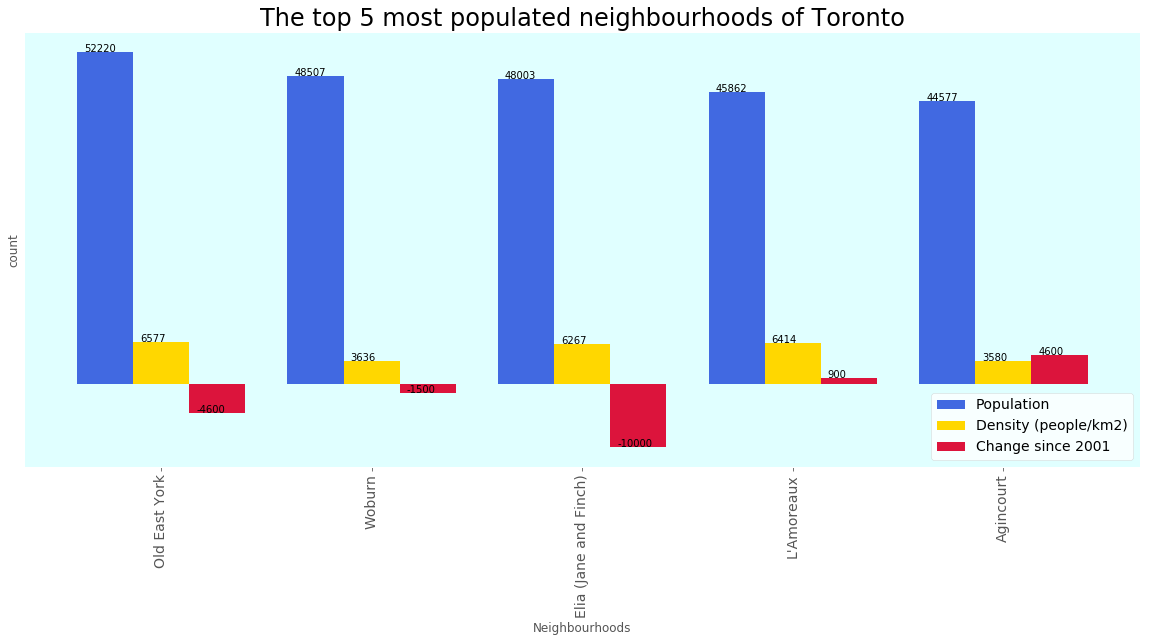

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#4169E1', '#FFD700', '#DC143C']
df_dens = df_dens.sort_values(['Population', 'Density (people/km2)'], ascending=False)
ax = df_dens[['Population', 'Density (people/km2)', 'Change since 2001']][:5].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightcyan')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('count')
plt.title('The top 5 most populated neighbourhoods of Toronto', fontsize=24)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0) if n <=19 else (b.y1 + b.y0)/1000)
    if n > 19:
        val += '%'
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

## Finding income trends

In [5]:
import re
df_ai = pd.DataFrame(Toronto_Demo[['Name','Average Income']])
df_ai.drop([0], inplace=True)
df_ai = df_ai.reset_index(drop=True)
df_ai.set_index(['Name'], inplace=True)

df_ai.head()
df_ai['Average Income'] = df_ai['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_ai['Average Income'].dtype
df_ai['Average Income'].values

array([ 25750,  35239,  19687, 245592,  27546, 116651,  92319,  34169,
        40598,  46752,  41485,  80827,  29723,  48965,  55578,  41605,
        27156, 314107,  27260,  50398, 103703,  23301,  82203,  34867,
        81288,  30556,  37653,  26610,  33392,  38182,  32701,  54681,
        23021, 104362,  28335,  55735,  80704,  41998,  40617,  47515,
        30442,  26525,  28311,  26751,  27961,  26672,  33847,  36206,
        25307,  22691,  34789,  28403,  63282,  63952,  23471, 101631,
        46086,  37614,  35022, 129904,  35277,  23350,  40806,  45792,
        69232,  22136,  56395,  46437,  33640,  33465, 222560,  39186,
        39738,  26117,  80618,  30907,  24297,  29576,  40404,  25078,
        43570,  28067,  23335,  32004,  30920,  26375,  46631,  29867,
        36361, 214110,  82670,  83853,  30886,  31231,  29224,  37288,
       127356,  25677,  27611,  51695,  30944,  25243,  47011, 154825,
        27139,  23910,  33415,  33428,  44611,  34330,  21155,  33517,
      

<Figure size 432x288 with 0 Axes>

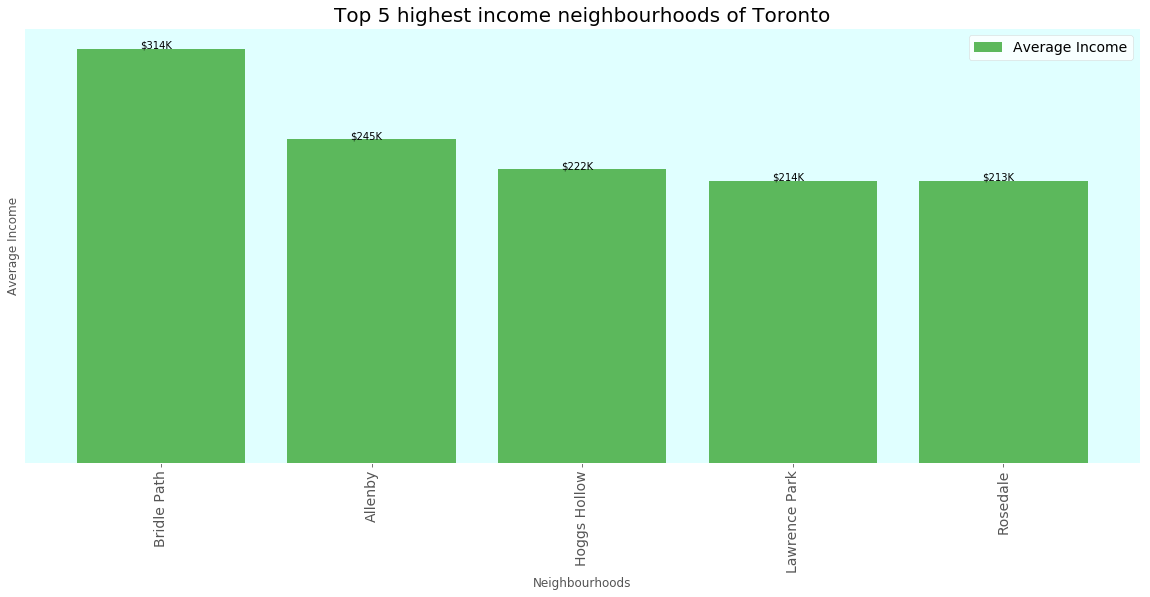

In [6]:
mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c']
df_ai = df_ai.sort_values(['Average Income'], ascending=False)
ax = df_ai[['Average Income']][:5].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightcyan')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Average Income')
plt.title('Top 5 highest income neighbourhoods of Toronto', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "${}K".format(int((b.y1 + b.y0)/1000))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

## Average income plot

Text(0.5, 1.0, 'Average Income - Toronto')

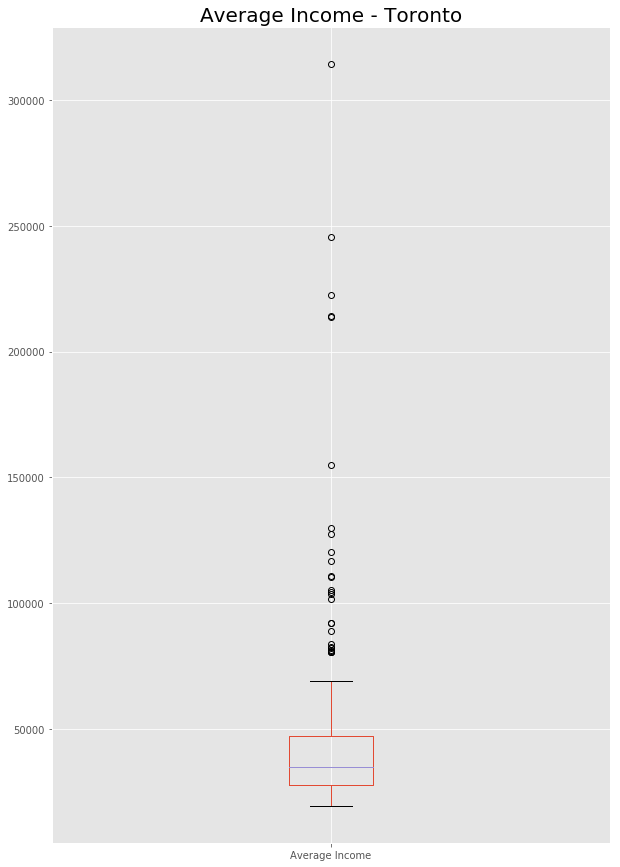

In [7]:
df_ai.plot.box(figsize=(10, 15))
plt.title('Average Income - Toronto', fontsize=20)

## Trade-off between income and population

In [8]:
import re
df_ip = pd.DataFrame(Toronto_Demo[['Average Income', 'Population']])
df_ip.drop([0], inplace=True)
df_ip.head()
df_ip['Average Income'] = df_ip['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_ip['Population'] = df_ip['Population'].apply(lambda x: int(x))
df_ip = df_ip.sort_values(['Population'])
df_ip = df_ip.reset_index(drop=True)
df_ip.head()

,Average Income,Population
0,63952,548
1,36243,571
2,43344,627
3,314107,1540
4,129904,2112


Text(0.5, 1.0, 'Trade-off betweeen Income & Population')

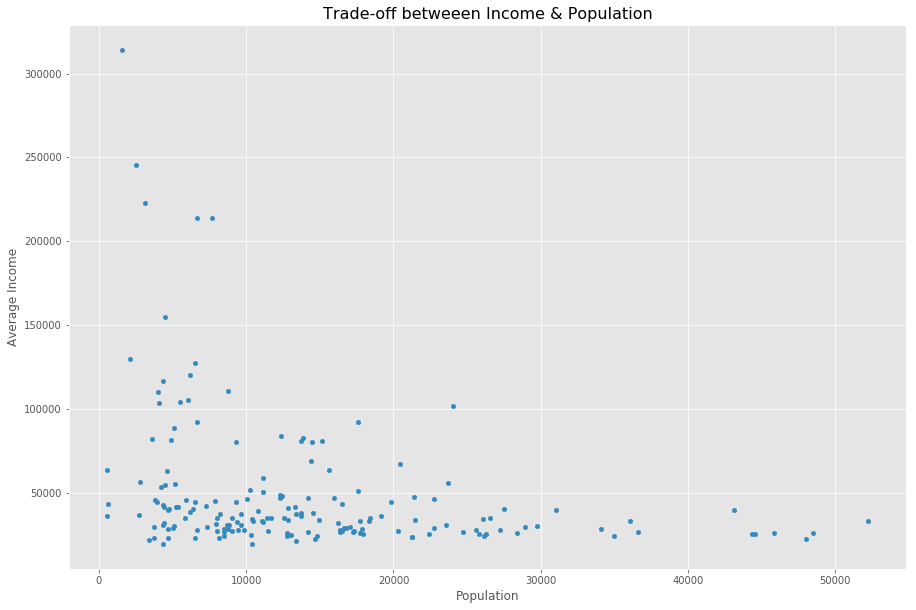

In [9]:
df_ip.plot.scatter(x='Population', y='Average Income', figsize=(15,10))
plt.title('Trade-off betweeen Income & Population', fontsize=16)

## Cleaning the Data for processing

In [10]:
columns_to_drop = [
    'FM', 
    'Census Tracts', 
    '% Change in Population since 2001', 
    'Land area (km2)', 
    'Transit Commuting\xa0%', 
    '% Renters', 
    'Second most common language (after English) by name', 
    'Map'
]

Toronto_Demo.drop(columns=columns_to_drop, inplace=True)

Toronto_Demo = Toronto_Demo.rename(columns={'Second most common language (after English) by percentage':'ESL'})
Toronto_Demo = Toronto_Demo.rename(columns={'Name':'Neighbourhood'})
Toronto_Demo.drop([0], inplace=True)
Toronto_Demo['Percentage'] = Toronto_Demo.apply (lambda row: row['ESL'].split('% ')[0],axis=1)
Toronto_Demo['Language'] = Toronto_Demo.apply (lambda row: row['ESL'].split('% ')[1],axis=1)
Toronto_Demo.drop(columns=['ESL'], inplace=True)

In [11]:
Toronto_Demo.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
3,Alexandra Park,4355,13609,19687,17.9,Cantonese
4,Allenby,2513,4333,245592,01.4,Russian
5,Amesbury,17318,4934,27546,06.1,Spanish


In [12]:
Toronto_Demo.describe()

,Population,Density (people/km2)
count,174.000000,174.000000
mean,13883.758621,6227.752874
std,10319.218850,6772.093019
min,548.000000,94.000000
25%,6258.000000,3123.250000
50%,11279.000000,4934.500000
75%,17705.500000,7580.000000
max,52220.000000,63765.000000


In [13]:
Toronto_Demo

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
3,Alexandra Park,4355,13609,19687,17.9,Cantonese
4,Allenby,2513,4333,245592,01.4,Russian
5,Amesbury,17318,4934,27546,06.1,Spanish
6,Armour Heights,4384,1914,116651,09.4,Russian
7,Banbury,6641,2442,92319,05.1,Unspecified Chinese
8,Bathurst Manor,14945,3187,34169,09.5,Russian
9,Bay Street Corridor,4787,43518,40598,09.6,Mandarin
10,Bayview Village,12280,2966,46752,08.4,Cantonese


## Analyzing the Data for Indian Community living in Toronto

In [14]:
df1 = pd.DataFrame(Toronto_Demo[Toronto_Demo['Language'].isin(['Punjabi', 'Tamil','Gujarati','Bengali','Urdu','Hindi'])])
df1.reset_index(drop=True)
df1 = df1.set_index(['Neighbourhood'])
df1

,Population,Density (people/km2),Average Income,Percentage,Language
Neighbourhood,,,,,
Bendale,28945,3409,29723,03.7,Tamil
Clairville,8506,1268,26610,12.0,Punjabi
Cliffcrest,14531,2073,38182,01.5,Tamil
Crescent Town,8157,20393,23021,18.1,Bengali
Dorset Park,14189,3331,26525,09.5,Tamil
Eglinton East,22387,6931,25307,09.7,Tamil
Flemingdon Park,21287,8760,23471,06.3,Urdu
Fort York/Liberty Village,3821,1794,46086,01.7,Hindi
Highland Creek,12853,2505,33640,05.1,Tamil


In [15]:

df_td_ru = pd.DataFrame(Toronto_Demo[Toronto_Demo['Language'].isin(['Punjabi', 'Tamil','Gujarati','Bengali','Urdu','Hindi'])])
df_td_ru.reset_index(drop=True)
#df_td_ru = pd.DataFrame(Toronto_Demographics[Toronto_Demographics['Language'].isin(['Russian', 'Ukrainian'])])
#df_td_ru.reset_index(drop=True)
df_td_ru = df_td_ru.set_index(['Neighbourhood'])
df_td_ru['Percentage'] = df_td_ru['Percentage'].apply(lambda x: float(x))
df_td_ru['Average Income'] = df_td_ru['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_td_ru['Population'] = df_td_ru['Population'].apply(lambda x: int(x))
df_td_ru['Indian'] = df_td_ru.apply(lambda x: int(x['Population'] * x['Percentage'] / 100), axis=1)
df_td_ru = df_td_ru.sort_values(['Indian'], ascending=False)
df_td_ru = df_td_ru.reset_index()
# df_td_ru = df_td_ru.set_index(['Neighbourhood'])
df_td_ru = df_td_ru.set_index(['Neighbourhood'])
df_td_ru

,Population,Density (people/km2),Average Income,Percentage,Language,Indian
Neighbourhood,,,,,,
Malvern,44324,5003,25677,12.2,Tamil,5407
Woburn,48507,3636,26190,9.1,Gujarati,4414
Smithfield,34996,5426,24387,11.8,Punjabi,4129
Thorncliffe Park,17949,5809,25340,21.5,Urdu,3859
Rouge,22724,791,29230,15.6,Tamil,3544
Eglinton East,22387,6931,25307,9.7,Tamil,2171
Humberwood,7319,421,29576,26.7,Punjabi,1954
Scarborough City Centre,16403,6358,26756,10.3,Tamil,1689
Oakridge,13368,7187,21155,12.6,Bengali,1684


<Figure size 432x288 with 0 Axes>

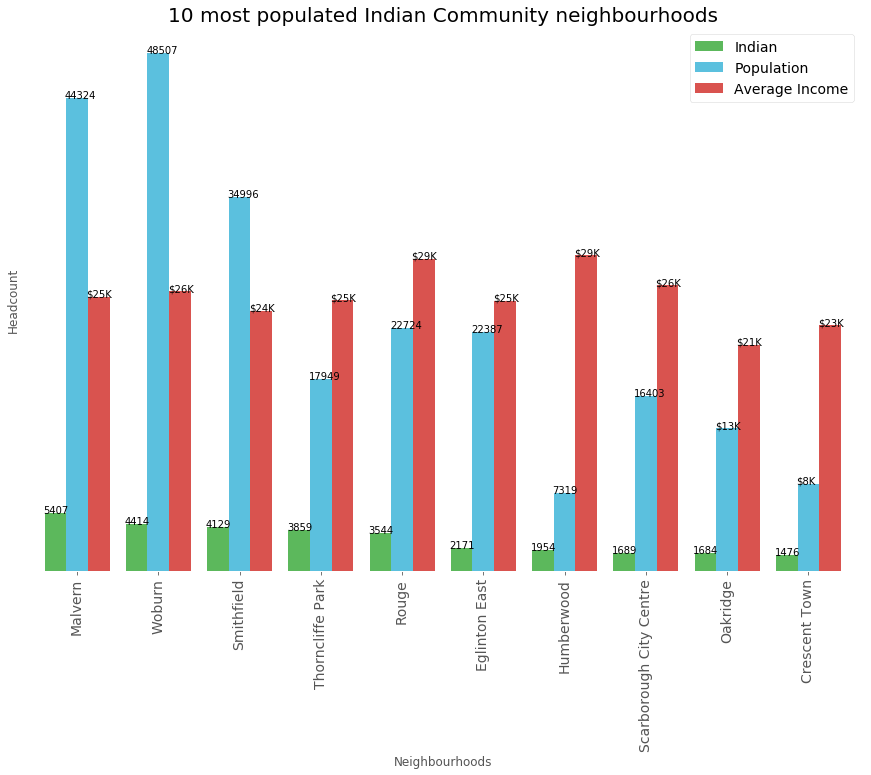

In [16]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c', '#5bc0de', '#d9534f']
df_dens = df_td_ru
# df_dens['Average Income'] = df_dens['Average Income'].apply(lambda x: int(x/10))
ax = df_dens[['Indian', 'Population', 'Average Income']][:10].plot(kind='bar', grid=False, color=colors, figsize=(15, 10), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('white')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Headcount')
plt.title('10 most populated Indian Community neighbourhoods', fontsize=20)
x_offset = -0.15
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0) if n <=17 else '$' + str(int((b.y1+b.y0)/1000))+'K')
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

Text(0.5, 1.0, 'Indian Community Population Average Income - Toronto')

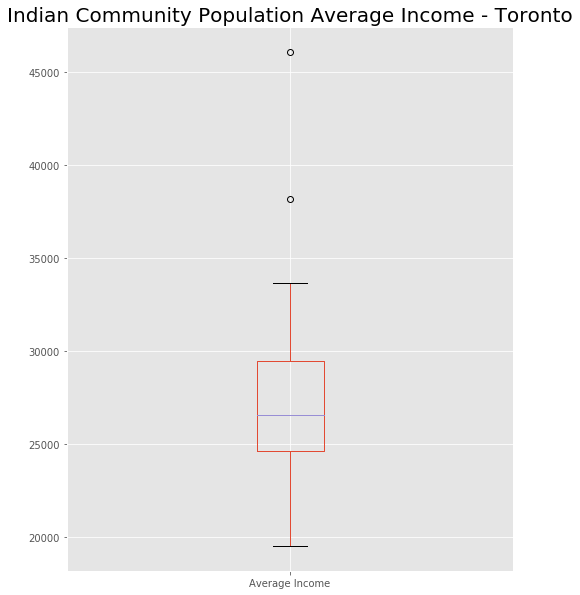

In [17]:
ru_avg_inc = df_td_ru[['Average Income']]
ru_avg_inc.plot.box(figsize=(8, 10))
plt.title('Indian Community Population Average Income - Toronto', fontsize=20)

Text(0.5, 1.0, 'Indian Population Average Income - Population in the city of Toronto')

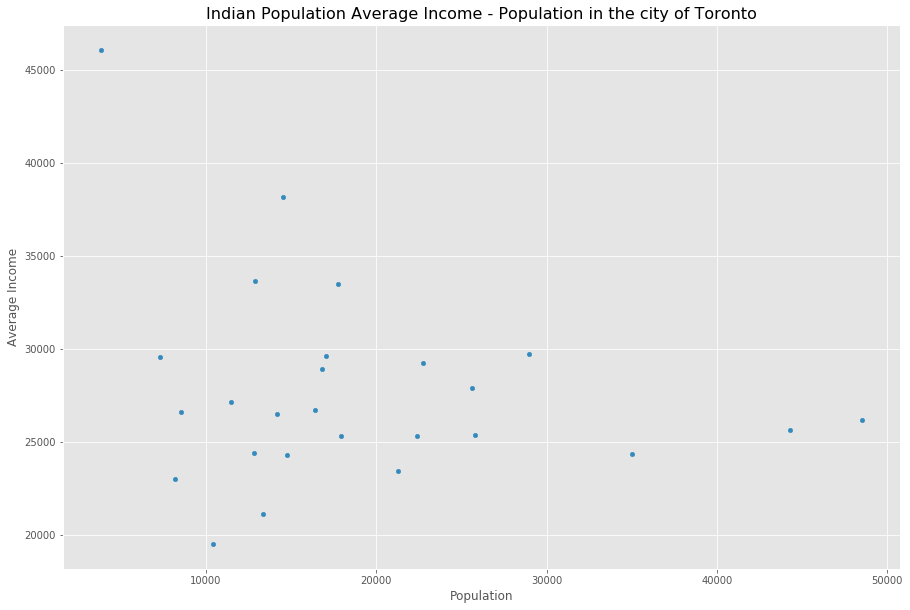

In [18]:
ru_avg = df_td_ru[['Population', 'Average Income']]
ru_avg.plot.scatter(x='Population', y='Average Income', figsize=(15,10))
plt.title('Indian Population Average Income - Population in the city of Toronto', fontsize=16)

<Figure size 432x288 with 0 Axes>

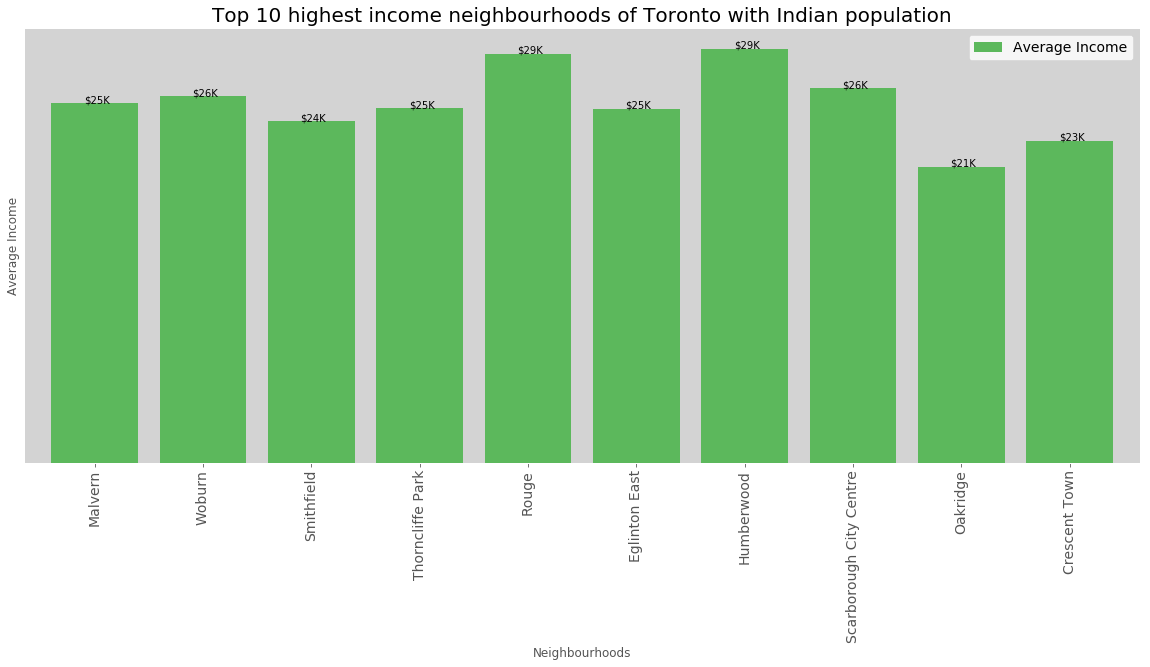

In [19]:
mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c']
df_avg = ru_avg.sort_values(['Average Income'], ascending=False)
ax = ru_avg[['Average Income']][:10].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightgray')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Average Income')
plt.title('Top 10 highest income neighbourhoods of Toronto with Indian population', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "${}K".format(int((b.y1 + b.y0)/1000))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

In [20]:
Toronto_geo_data = pd.read_csv("Toronto_geo_data.csv")
Toronto_geo_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,Rouge,43.806686,-79.194353
1,M1B,Scarborough,Malvern,43.806686,-79.194353
2,M1C,Scarborough,Highland Creek,43.784535,-79.160497
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
4,M1C,Scarborough,Port Union,43.784535,-79.160497


In [21]:
list_of_neighbourhoods = Toronto_Demo['Neighbourhood'].values.tolist()

### Matching the two datasets we have

In [22]:
list_missing_neigh = []
for neigh in list_of_neighbourhoods:
    if neigh not in Toronto_geo_data['Neighbourhood'].values and neigh not in Toronto_geo_data['Borough']:
        list_missing_neigh.append(neigh)
list_missing_neigh

['Alexandra Park',
 'Allenby',
 'Amesbury',
 'Armour Heights',
 'Banbury',
 'Bay Street Corridor',
 'Bayview Woods – Steeles',
 'Bendale',
 'Bloor West Village',
 'Bracondale Hill',
 'Branson',
 'Bridle Path',
 'Caribou Park',
 'Carleton Village',
 'Casa Loma',
 'Centennial',
 'Chaplin Estates',
 'Christie Pits',
 'Clairville',
 'Corktown',
 'Crescent Town',
 'Cricket Club',
 'Davenport',
 'Discovery District',
 'Distillery District/West Don Lands',
 'Don Mills',
 'Don Valley Village',
 'Dovercourt Park',
 'Dufferin Grove',
 'Earlscourt',
 'East Danforth',
 'Eatonville',
 'Eglinton East',
 'Elia (Jane and Finch)',
 'Fairbank',
 'Fashion District',
 'Financial District',
 'Forest Hill',
 'Fort York/Liberty Village',
 'Glen Park',
 "Governor's Bridge/Bennington Heights",
 'Graydon Hall',
 'Harbord Village',
 'Harbourfront / CityPlace',
 'Harwood',
 'High Park North',
 'Hillcrest',
 'Hoggs Hollow',
 'Humber Heights',
 'Humber Valley Village',
 'Humbermede',
 'Humberwood',
 'Humewood–Cedar

In [23]:
Toronto_Demo  = Toronto_Demo[~Toronto_Demo.Neighbourhood.isin(list_missing_neigh)]


In [ ]:
Toronto_Demo.reset_index(drop=True)

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
0,Agincourt,44577,3580,25750,19.3,Cantonese
1,Alderwood,11656,2360,35239,06.2,Polish
2,Bathurst Manor,14945,3187,34169,09.5,Russian
3,Bayview Village,12280,2966,46752,08.4,Cantonese
4,Bedford Park,13749,6057,80827,00.7,Greek
5,Birch Cliff,12266,3525,48965,00.9,Unspecified Chinese
6,Brockton,9039,8217,27260,19.9,Portuguese
7,Cabbagetown,11120,7943,50398,01.6,Unspecified Chinese
8,Church and Wellesley,13397,24358,37653,01.8,Spanish
9,Clairlea,11104,3102,33392,04.3,Filipino


In [ ]:
list_exist_neigh_dem = Toronto_Demo['Neighbourhood'].values.tolist()

In [ ]:
Toronto_Demo = Toronto_Demo[Toronto_Demo.Neighbourhood.isin(list_exist_neigh_dem)]
Toronto_Demo.reset_index(drop=True)
Toronto_Demo.shape

(78, 6)

In [ ]:
Toronto_Demo.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
8,Bathurst Manor,14945,3187,34169,09.5,Russian
10,Bayview Village,12280,2966,46752,08.4,Cantonese
12,Bedford Park,13749,6057,80827,00.7,Greek


In [ ]:
Toronto_geo_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,Rouge,43.806686,-79.194353
1,M1B,Scarborough,Malvern,43.806686,-79.194353
2,M1C,Scarborough,Highland Creek,43.784535,-79.160497
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
4,M1C,Scarborough,Port Union,43.784535,-79.160497


## Combining the two datasets

In [ ]:
Toronto_Merged = pd.merge(Toronto_geo_data, Toronto_Demo, on='Neighbourhood')

In [ ]:
Toronto_Merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil
1,M1B,Scarborough,Malvern,43.806686,-79.194353,44324,5003,25677,12.2,Tamil
2,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12853,2505,33640,05.1,Tamil
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497,11167,2878,32858,02.4,Filipino
4,M1C,Scarborough,Port Union,43.784535,-79.160497,12450,2310,48117,01.6,Filipino
5,M1E,Scarborough,Guildwood,43.763573,-79.188711,12820,2688,40806,01.2,Persian
6,M1E,Scarborough,Morningside,43.763573,-79.188711,11472,4112,27139,10.8,Tamil
7,M1E,Scarborough,West Hill,43.763573,-79.188711,25632,2676,27936,03.0,Tamil
8,M1G,Scarborough,Woburn,43.770992,-79.216917,48507,3636,26190,09.1,Gujarati
9,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,12796,6303,24413,11.4,Tamil


In [ ]:
Toronto_Merged.drop_duplicates(keep='first', inplace=True)

## Creating a map of Toronto Neighbourhoods

In [ ]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
T_lat = location.latitude
T_lon = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(T_lat, T_lon))

The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


In [ ]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_geo_data['Latitude'], Toronto_geo_data['Longitude'], Toronto_geo_data['Borough'], Toronto_geo_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

## Preparing foursquare credintials

In [ ]:
CLIENT_ID = 'LK2AIRIBOALCSFA440RKC3UJSMLTKNSBPDOERCXJO2H25EYX'
CLIENT_SECRET = 'BVWG13R5QSUME0Z253RYPTENUB01PBMXFQ03CYKVGPO4MHU5'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LK2AIRIBOALCSFA440RKC3UJSMLTKNSBPDOERCXJO2H25EYX
CLIENT_SECRET:BVWG13R5QSUME0Z253RYPTENUB01PBMXFQ03CYKVGPO4MHU5


## Creating a new Dataframe for Indian ethnic group in Toronto

In [ ]:
df_IN = Toronto_Merged[Toronto_Merged.Language.isin(['Punjabi', 'Tamil','Gujarati','Bengali','Urdu','Hindi'])]
df_IN = df_IN.sort_values(by=['Percentage','Population'], ascending=False)
df_IN.reset_index(drop=True)


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M4H,East York,Thorncliffe Park,43.705369,-79.349372,17949,5809,25340,21.5,Urdu
1,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil
2,M1L,Scarborough,Oakridge,43.711112,-79.284577,13368,7187,21155,12.6,Bengali
3,M1B,Scarborough,Malvern,43.806686,-79.194353,44324,5003,25677,12.2,Tamil
4,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,12796,6303,24413,11.4,Tamil
5,M1E,Scarborough,Morningside,43.763573,-79.188711,11472,4112,27139,10.8,Tamil
6,M1P,Scarborough,Dorset Park,43.757410,-79.273304,14189,3331,26525,09.5,Tamil
7,M1G,Scarborough,Woburn,43.770992,-79.216917,48507,3636,26190,09.1,Gujarati
8,M9V,Etobicoke,Thistletown,43.739416,-79.588437,16790,4229,28955,08.6,Punjabi
9,M3C,North York,Flemingdon Park,43.725900,-79.340923,21287,8760,23471,06.3,Urdu


In [ ]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_IN['Latitude'], df_IN['Longitude'], df_IN['Borough'], df_IN['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

## Getting the neighbourhood with  most Indian population

In [ ]:
IN_lat = df_IN['Latitude'].values[0] # neighborhood latitude value
IN_lon = df_IN['Longitude'].values[0] # neighborhood longitude value
IN_name = df_IN['Neighbourhood'].values[0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(IN_name, 
                                                               IN_lat, 
                                                               IN_lon))

## Getting location insights from Foursquare


In [ ]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    IN_lat, 
    IN_lon, 
    radius, 
    LIMIT)
url

In [ ]:
results = requests.get(url).json()
if results != None:
    print("Request successfully processed")

## Getting the types of business oppurtunity near the area with highest indian population

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]



print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
IN_venues = getNearbyVenues(names=df_IN['Neighbourhood'],
                                   latitudes=df_IN['Latitude'],
                                   longitudes=df_IN['Longitude']
                                  )

In [ ]:
print(IN_venues.shape)
IN_venues.head()

## Get count of venues in the neighbourhoods with the highest population of Indians

In [ ]:
IN_venues.groupby('Neighborhood').count()

In [ ]:
print('There are {} uniques categories.'.format(len(IN_venues['Venue Category'].unique())))

## Perform one-hot encoding on the venues

In [ ]:
IN_onehot = pd.get_dummies(IN_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
IN_onehot['Neighborhood'] = IN_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [IN_onehot.columns[-1]] + list(IN_onehot.columns[:-1])
IN_onehot = IN_onehot[fixed_columns]

IN_onehot.head()


In [ ]:
IN_onehot.shape


## Group the venues by neighbourhoods with Indians

In [ ]:
IN_grouped = IN_onehot.groupby('Neighborhood').mean().reset_index()
IN_grouped

In [ ]:
IN_grouped.shape
IN_stats = IN_grouped.describe()
IN_stats

In [ ]:
IN_stats.plot.hist(bins=IN_stats.shape[1], figsize=(15,10))
plt.legend(loc='upper right')
plt.show()

## Report venue frequency per neighbourhood with the highest population of Indians

In [ ]:
num_top_venues = 10

for hood in IN_grouped['Neighborhood']:
    temp = IN_grouped[IN_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp.plot.hist(bins=5)
    print(hood)
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

## Listing most common venues

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def return_least_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_least_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of bottom venues
columns = ['Neighborhood']
for ind in np.arange(num_least_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = IN_grouped['Neighborhood']

for ind in np.arange(IN_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(IN_grouped.iloc[ind, :], num_least_venues)

neighborhoods_venues_sorted

## List least common venues - Lowest venue frequncy presents the highest returns for business with the least amount of competition

In [ ]:
num_least_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of bottom venues
columns = ['Neighborhood']
for ind in np.arange(num_least_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = IN_grouped['Neighborhood']

for ind in np.arange(IN_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_least_common_venues(IN_grouped.iloc[ind, :], num_least_venues)

neighborhoods_venues_sorted

# Perform Neighbourhood Cluster Analysis

In [ ]:
kclusters = 8

IN_grouped_clustering = IN_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(IN_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


## Merge the results with the clusters¶

In [ ]:
IN_grouped_clustering

In [ ]:
df_IN

In [ ]:
df_IN_merged = df_IN
df_IN_merged

In [ ]:
df_IN_merged['Cluster Labels'] = kmeans.labels_
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_IN_merged = df_IN_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

df_IN_merged.head(10)

# Draw a map of the location most suitable for opening a new business venture targeting the demographic with the highest population of Indians¶

In [ ]:
map_clusters = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_IN_merged['Latitude'], df_IN_merged['Longitude'], df_IN_merged['Neighbourhood'], df_IN_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        #color=rainbow[cluster-1],
        color='green',
        fill=True,
      #  fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Suggest the following business ventures based on the lowest frequncy of venues in the 1st cluster

In [ ]:
df_IN_merged.loc[df_IN_merged['Cluster Labels'] == 0, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]

## Suggest the following business ventures based on the lowest frequncy of venues in the 2nd cluster

In [ ]:
df_IN_merged.loc[df_IN_merged['Cluster Labels'] == 1, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]

## Suggest the following business ventures based on the lowest frequncy of venues in the 3rd cluster

In [ ]:
df_IN_merged.loc[df_IN_merged['Cluster Labels'] == 2, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]

## Suggest the following business ventures based on the lowest frequncy of venues in the 4th cluster

In [ ]:
df_IN_merged.loc[df_IN_merged['Cluster Labels'] == 3, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]

## Suggest the following business ventures based on the lowest frequncy of venues in the 5th cluster¶

In [ ]:
df_IN_merged.loc[df_IN_merged['Cluster Labels'] == 4, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]

## Suggest the following business ventures based on the lowest frequncy of venues in the 6th cluster¶

In [ ]:
df_IN_merged.loc[df_IN_merged['Cluster Labels'] == 5, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]

## Suggest the following business ventures based on the lowest frequncy of venues in the 7th cluster¶

In [ ]:
df_IN_merged.loc[df_IN_merged['Cluster Labels'] == 6, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]

## Suggest the following business ventures based on the lowest frequncy of venues in the 8th cluster¶

In [ ]:
df_IN_merged.loc[df_IN_merged['Cluster Labels'] == 7, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]

# Recommendation Report: We recommend the following venues targeting the Indian demographic

## Locations

In [ ]:
map_clusters = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_IN_merged['Latitude'], df_IN_merged['Longitude'], df_IN_merged['Neighbourhood'], df_IN_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        #color=rainbow[cluster-1],
        color='red',
        fill=True,
 #       fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## List of recommended venues per each cluster

In [ ]:
dict_suggested_venues = {}
for x in range(0, kclusters):
    df = df_IN_merged.loc[df_IN_merged['Cluster Labels'] == x, df_IN_merged.columns[[1,2]]]
    label = df.values[0][0] + '-' + df.values[0][1]
    df1 = df_IN_merged.loc[df_IN_merged['Cluster Labels'] == x, df_IN_merged.columns[[1] + list(range(5, df_IN_merged.shape[1]))]]
    dict_suggested_venues[label] = df1.values[0][7:]
    
rec_df = pd.DataFrame.from_dict(dict_suggested_venues, orient='index')
dict_rename_cols = {}
for i in range(0, 10):
    dict_rename_cols[i] = 'Venue {}'.format(i)
rec_df = rec_df.rename(columns=dict_rename_cols)
rec_df

In [ ]:
df_pop = df_IN[['Population', 'Neighbourhood']]
df_pop = df_pop.set_index('Neighbourhood')
df_pop.plot.bar(figsize=(10,5))
plt.ylabel('Population')
plt.show()

In [ ]:
df_inc = df_IN[['Average Income', 'Neighbourhood']]
df_inc = df_inc.set_index('Neighbourhood')
df_inc = df_inc.apply(pd.to_numeric, errors='ignore')

fig = plt.figure()
ax = fig.add_subplot()

ax = df_inc.plot.pie(subplots=True, figsize=(10, 7), )

legend = plt.legend(frameon = 1, fontsize=8)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xticks([])
plt.ylabel= ''

plt.legend(loc='upper right')
plt.title('Target Group Average Income Distribution', fontsize=20)

plt.show()

In [ ]:
df_inc = df_IN[['Average Income', 'Neighbourhood']]
df_inc = df_inc.set_index('Neighbourhood')
df_inc = df_inc.apply(pd.to_numeric, errors='ignore')
df_inc.plot.bar(grid=True, figsize=(10,7))

## THANKYOU FOR THE PATIENCE